# Sequence Embeddings dos Hinos da ICM
Este notebook explora técnicas de sequence embeddings para representar os textos completos dos hinos da coletânea principal da Igreja Cristã Maranata.

O objetivo é aplicar modelos de embeddings de sentenças, calcular similaridade, realizar agrupamentos, buscar hinos por texto e extrair tópicos com BERTopic.

---
**Conteúdo do notebook:**
- Carregamento do modelo SentenceTransformer e dos dados tratados
- Geração de embeddings para cada hino
- Cálculo de similaridade entre hinos
- Visualização de matrizes de similaridade
- Redução de dimensionalidade (t-SNE, UMAP)
- Agrupamento de hinos por KMeans
- Busca de hinos por texto
- Extração de tópicos com BERTopic
- Visualização dos agrupamentos e tópicos
- Salvamento dos resultados para uso futuro

Este material é público e pode ser compartilhado para fins de pesquisa, estudo ou divulgação cultural.

# Parte 4 - Sequence embeddings

---

**A seguir:** Carregamento do modelo SentenceTransformer para geração de embeddings de sentenças dos hinos.

In [1]:
from sentence_transformers import SentenceTransformer

# Diversas opções de modelos:
# model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
# model = SentenceTransformer("neuralmind/bert-base-portuguese-cased")
# model = SentenceTransformer("rufimelo/Legal-BERTimbau-sts-base")  # português brasileiro
model = SentenceTransformer(
    "paraphrase-multilingual-MiniLM-L12-v2"
)  # mais leve e eficiente

---

**A seguir:** Carregamento dos dados dos hinos já enriquecidos com embeddings anteriores, prontos para análise de sentenças.

In [2]:
import pandas as pd

hinos_analise: pd.DataFrame = pd.read_pickle(
    "..\\assets\\hinos_analise_word_embeddings.pkl"
)

---

**A seguir:** Geração dos embeddings de sentenças para cada hino, representando o texto completo em um vetor denso.

In [3]:
import numpy as np

# cria embeddings diretamente para cada hino (texto inteiro)
embeddings = model.encode(hinos_analise["texto_limpo"].tolist(), show_progress_bar=True)
X_sent = np.array(embeddings)
hinos_analise["sent_embeddings"] = list(X_sent)

print(X_sent.shape)

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

(795, 384)


---

**A seguir:** Cálculo da similaridade entre hinos usando os embeddings de sentenças, identificação dos hinos mais semelhantes ao hino de referência.

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X_sent)

# hinos mais semelhantes ao hino 443
similarities = list(enumerate(similarity_matrix[443]))
similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

print("Mais parecidos com o hino 443:")
for idx, score in similarities[1:6]:
    print(f"Hino {idx}: {hinos_analise['nome'].iloc[idx]} → similaridade {score:.3f}")

Mais parecidos com o hino 443:
Hino 86: EM TEU NOME → similaridade 0.918
Hino 310: MESTRE O MAR SE REVOLTA → similaridade 0.916
Hino 724: EIS OS MILHÕES → similaridade 0.913
Hino 513: QUEM É ESTA QUE APARECE → similaridade 0.913
Hino 265: LEVA TU CONTIGO O NOME → similaridade 0.911


---

**A seguir:** Visualização da matriz de similaridade entre hinos utilizando heatmap para facilitar a análise dos padrões de similaridade.

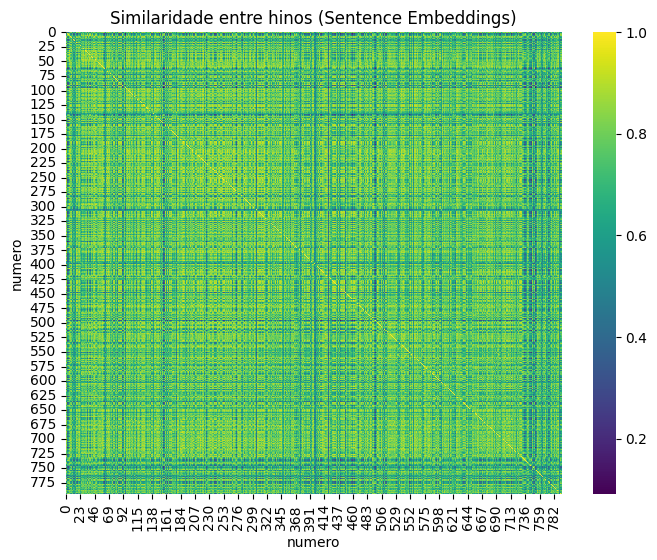

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

similarity_matrix_df = pd.DataFrame(
    similarity_matrix, index=hinos_analise.index, columns=hinos_analise.index
)

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix_df, cmap="viridis", annot=False, cbar=True)
plt.title("Similaridade entre hinos (Sentence Embeddings)")
plt.show()

---

**A seguir:** Redução de dimensionalidade dos embeddings dos hinos utilizando t-SNE e UMAP para visualização e agrupamento.

c:\ProgramData\anaconda3\envs\jupyters\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


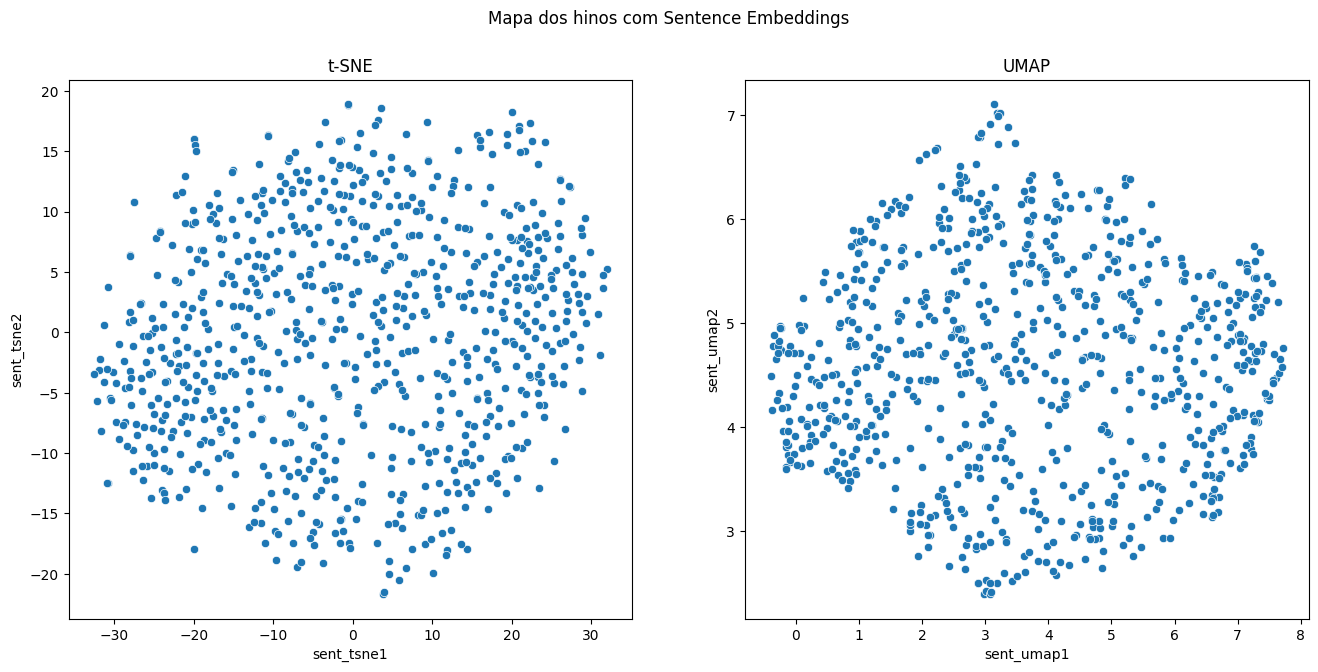

In [6]:
import umap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,  # 2D
    perplexity=30,
    random_state=42,
)
X_tsne = tsne.fit_transform(X_sent)

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_sent)

hinos_analise["sent_tsne1"] = X_tsne[:, 0]
hinos_analise["sent_tsne2"] = X_tsne[:, 1]

hinos_analise["sent_umap1"] = X_umap[:, 0]
hinos_analise["sent_umap2"] = X_umap[:, 1]

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.scatterplot(data=hinos_analise, x="sent_tsne1", y="sent_tsne2", ax=ax[0])
ax[0].set_title("t-SNE")
sns.scatterplot(data=hinos_analise, x="sent_umap1", y="sent_umap2", ax=ax[1])
ax[1].set_title("UMAP")
plt.suptitle("Mapa dos hinos com Sentence Embeddings")
plt.show()

---

**A seguir:** Análise de agrupamento dos hinos utilizando KMeans, avaliação do número ideal de clusters com o coeficiente de Silhouette.

k = 2, silhouette = 0.4810
k = 3, silhouette = 0.4042
k = 4, silhouette = 0.4557
k = 5, silhouette = 0.4314
k = 6, silhouette = 0.4265
k = 7, silhouette = 0.3974
k = 8, silhouette = 0.4001
k = 9, silhouette = 0.3967
k = 10, silhouette = 0.3940
k = 11, silhouette = 0.3807


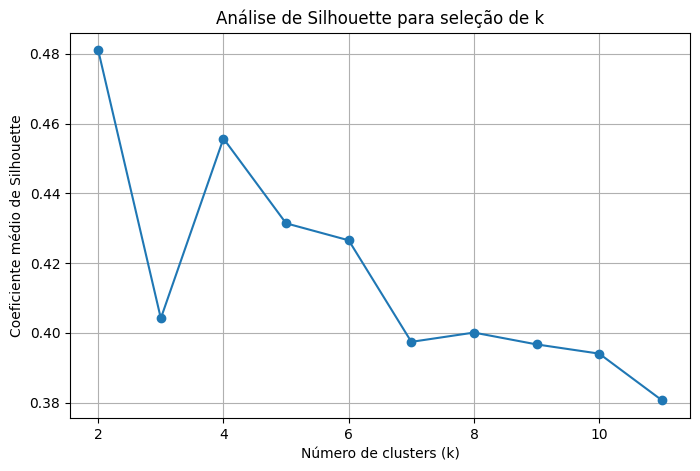

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


range_n_clusters = range(2, 12)
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels)
    silhouette_scores.append(score)
    print(f"k = {k}, silhouette = {score:.4f}")

# Visualiza o resultado
plt.figure(figsize=(8, 5))
plt.plot(range_n_clusters, silhouette_scores, marker="o")
plt.title("Análise de Silhouette para seleção de k")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficiente médio de Silhouette")
plt.grid(True)
plt.show()

---

**A seguir:** Visualização dos agrupamentos dos hinos por embeddings reduzidos, utilizando scatterplot para UMAP e clusters do KMeans.

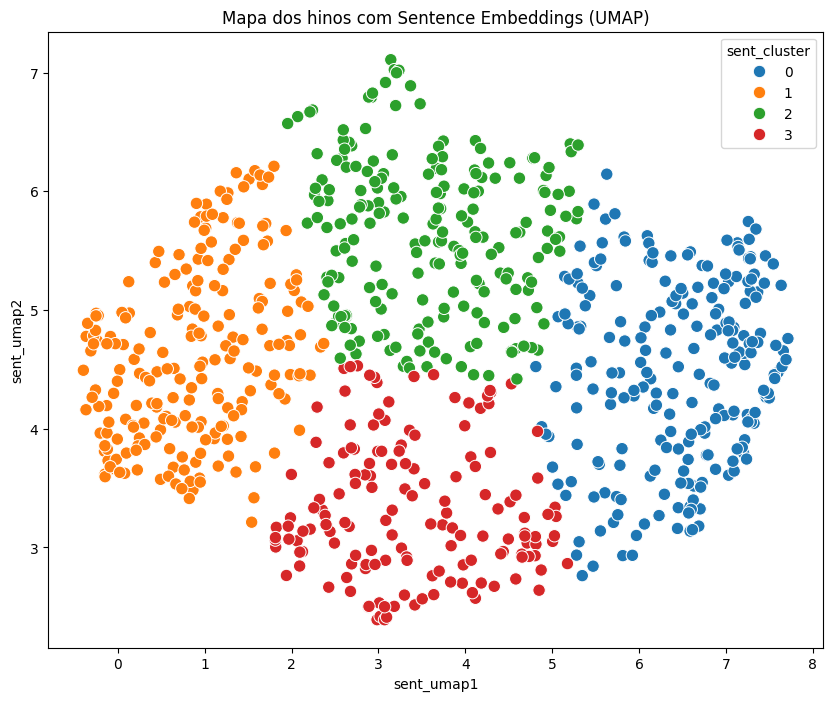

In [8]:
# número de clusters (experimente, ex.: 4 ou 6)
kmeans = KMeans(n_clusters=4, random_state=42)
hinos_analise["sent_cluster"] = kmeans.fit_predict(X_umap)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=hinos_analise,
    x="sent_umap1",
    y="sent_umap2",
    hue="sent_cluster",
    palette="tab10",
    s=80,
)
plt.title("Mapa dos hinos com Sentence Embeddings (UMAP)")
plt.show()

---

**A seguir:** Análise dos termos mais frequentes em cada cluster e visualização da distribuição dos hinos por cluster.

In [9]:
from collections import Counter

for c in sorted(hinos_analise["sent_cluster"].unique()):
    cluster_tokens = hinos_analise.loc[
        hinos_analise["sent_cluster"] == c, "tokens_no_stops"
    ].sum()
    top_terms = Counter(cluster_tokens).most_common(10)
    print(f"\nCluster {c}:")
    print([t for t, _ in top_terms])
    print(hinos_analise.loc[hinos_analise["sent_cluster"] == c, "nome"][:5])

print(hinos_analise["sent_cluster"].value_counts().sort_index())


Cluster 0:
['senhor', 'deus', 'amor', 'vem', 'glória', 'sempre', 'vida', 'sim', 'jesus', 'cristo']
numero
0     AQUILO QUE FUI NÃO SOU MAIS
3                      CLAMO A TI
9           SENHOR, ME CHEGO A TI
12            HÁ VITÓRIA PARA MIM
17       EM TUA PRESENÇA ENTRAMOS
Name: nome, dtype: object

Cluster 1:
['jesus', 'senhor', 'glória', 'vem', 'amor', 'cristo', 'deus', 'vida', 'sangue', 'paz']
numero
2     O SANGUE DE JESUS TEM PODER PARA SALVAR
4                        QUANDO TE PROSTRARES
5                              CLAMANDO ESTOU
6                          JESUS, Ó MEU JESUS
10                      VAMOS LAVAR AS VESTES
Name: nome, dtype: object

Cluster 2:
['jesus', 'senhor', 'deus', 'amor', 'vem', 'cristo', 'glória', 'vida', 'rei', 'paz']
numero
1        O SANGUE DE JESUS TEM PODER
7               NESTA HORA EM ORAÇÃO
8               PELO SANGUE DE JESUS
20    O TEU PECADO TU QUERES DEIXAR?
21              NESTA HORA DE CLAMOR
Name: nome, dtype: object

Cluster 3:
['senho

---

**A seguir:** Busca de hinos por similaridade textual, utilizando embeddings para encontrar os hinos mais próximos de uma consulta em linguagem natural.

In [10]:
query = "a palavra é alimento para a alma"
query_vec = model.encode([query])

scores = cosine_similarity(query_vec, X_sent)[0]
top_idx = np.argsort(scores)[::-1][:10]

print("Top hinos para a busca:")
for i in top_idx:
    print(f"Hino {i}: {hinos_analise['nome'].iloc[i]} → score {scores[i]:.3f}")

Top hinos para a busca:
Hino 164: É BASTANTE PARA MIM A TUA GRAÇA → score 0.568
Hino 424: O MEU AMADO DESCEU AO SEU JARDIM → score 0.553
Hino 615: LOUVOR E GLÓRIA → score 0.550
Hino 674: EU NÃO SEI QUAL SERÁ O LOUVOR → score 0.531
Hino 178: O DEUS A QUEM SERVIMOS → score 0.526
Hino 621: ADORAR-TE → score 0.526
Hino 177: SEMPRE VOU LEMBRAR O QUE FIZESTE POR MIM → score 0.513
Hino 426: UM CORPO SÓ, UM SÓ ESPÍRITO → score 0.511
Hino 781: SÓ O PODER DE DEUS → score 0.510
Hino 249: SE EM TUA VIDA FALTA PAZ → score 0.508


---

**A seguir:** Extração de tópicos dos hinos utilizando BERTopic, atribuição dos tópicos aos hinos e visualização da distribuição dos tópicos.

# Tópicos

---

**A seguir:** Visualização dos agrupamentos dos hinos por tópicos extraídos com BERTopic, utilizando scatterplot para UMAP.

In [11]:
from bertopic import BERTopic

# Criar o modelo BERTopic
topic_model = BERTopic(embedding_model=model)

# Treinar modelo
topics, probs = topic_model.fit_transform(hinos_analise["texto_limpo"])

# Associar tópicos ao DataFrame
hinos_analise["BERT_topic"] = topics

---

**A seguir:** Visualização dos agrupamentos dos hinos por tópicos em diferentes projeções (UMAP), utilizando BERTopic.

In [12]:
print("\nDistribuição de tópicos por hino:")
print(hinos_analise["BERT_topic"].value_counts())

# Mostrar os tópicos descobertos
print("\nTópicos extraídos:")
for topic_num in set(topics):
    if (
        topic_num != -1
    ):  # -1 significa "outlier" (documento não encaixou em nenhum cluster)
        palavras = topic_model.get_topic(topic_num)
        print(f"Tópico {topic_num}:")
        print([word for word, _ in palavras])


Distribuição de tópicos por hino:
BERT_topic
 0    779
 1     15
-1      1
Name: count, dtype: int64

Tópicos extraídos:
Tópico 0:
['que', 'de', 'jesus', 'senhor', 'meu', 'me', 'em', 'deus', 'eu', 'do']
Tópico 1:
['jerusalém', 'de', 'deus', 'tua', 'israel', 'cidade', 'teu', 'senhor', 'hosana', 'que']


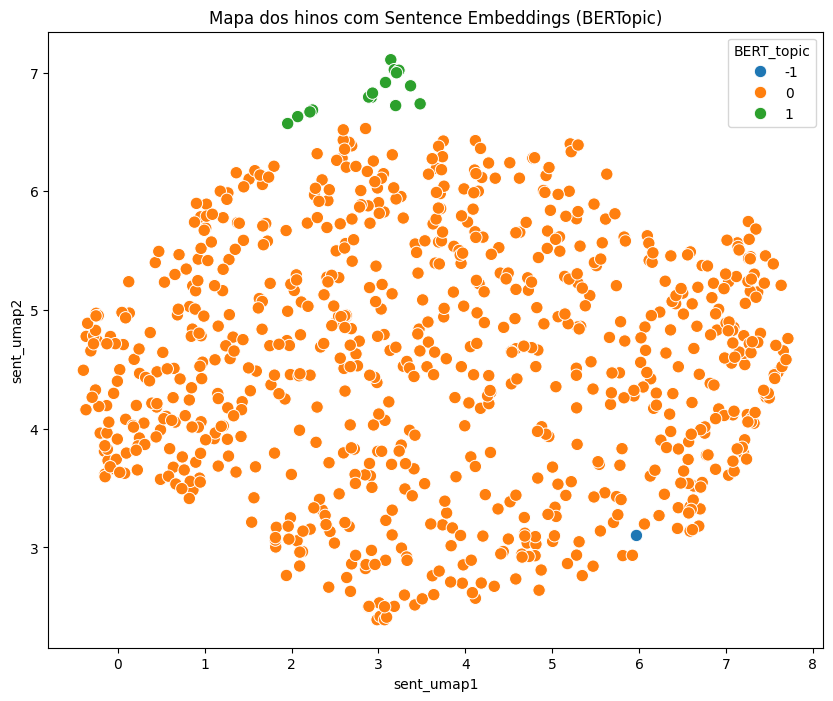

In [13]:
# número de clusters (experimente, ex.: 4 ou 6)
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=hinos_analise,
    x="sent_umap1",
    y="sent_umap2",
    hue="BERT_topic",
    palette="tab10",
    s=80,
)
plt.title("Mapa dos hinos com Sentence Embeddings (BERTopic)")
plt.show()

---

**A seguir:** Salvamento dos resultados e informações enriquecidas dos hinos para uso em análises futuras.

# Salvamento de informações novas

---

**Fim do notebook:** Finalização do processamento, com os dados prontos para exportação e uso em outras análises ou aplicações.

In [14]:
hinos_analise.to_pickle("..\\assets\\hinos_analise_embeddings_complete.pkl")

In [15]:
similarity_matrix_df.to_pickle("..\\assets\\similarity_matrix_sentence_embeddings.pkl")